In [1]:
import pandas as pd
import panel as pn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.figure import Figure
import param
#import hvplot.pandas
import altair as alt
import requests
#import streamlit as st
import pywaffle
from pywaffle import Waffle

In [229]:
data = pd.read_csv('/Users/sarahweinflash/Desktop/Education/CIS 9655 - Data Visualization/Cleaned_Data.csv')

In [230]:
data['Injuries'] = data['Value']
data = data[['Country','Year','Injuries']]
data = data[data['Year']<2022]

Country = []
for i in data['Country']:
  Country.append(i.title())
data['Country'] = Country

In [10]:
# Boxplot

alt.Chart(data, title = 'Injuries in Road Accidents - Per Million Population').mark_boxplot().encode(
    x = 'Year:O',
    y = 'Injuries:Q'
)

alt.Chart(...)

In [50]:
# Boxplot - Sort by Injuries

order = data.groupby('Country').agg('sum')
order = order.sort_values('Injuries', ascending=False)
order = list(order.index)

alt.Chart(data, title = 'Injuries in Road Accidents - Per Million Population').mark_boxplot(color='green').encode(
    x = alt.X('Country:N', sort=order),
    y = 'Injuries:Q'
)

alt.Chart(...)

In [196]:
# Scatter Plot - Input Dropdown

input_dropdown = alt.binding_select(options=list(data['Year'].unique()), name='Year')
selection = alt.selection_point(fields=['Year'], bind=input_dropdown)
opacity = alt.condition(selection, alt.value(1.0), alt.value(0))

alt.Chart(data, title = 'Injuries in Road Accidents - Per Million Population').mark_point(filled=True, size=50, color='purple').encode(
    x = 'Country:N',
    y = 'Injuries:Q',
    opacity = opacity
).add_params(selection)

alt.Chart(...)

In [221]:
# Scatter - Button Selection

options= [i for i in list(data['Year'].unique())]
labels= [f'{str(i)}' for i in list(data['Year'].unique())]

input_dropdown = alt.binding_radio(
    options= options + [None],
    labels= labels + ['All'],
    name='Year: '
)

selection = alt.selection_point(
    fields=['Year'],
    bind=input_dropdown
)

opacity = alt.condition(selection, alt.value(1.0), alt.value(0))

alt.Chart(data, title = 'Injuries in Road Accidents - Per Million Population').mark_circle(color = 'orange').encode(
    x = alt.X('Country:N', scale=alt.Scale(domain=list(data['Country'].unique()))),
    y = alt.Y('Injuries:Q', scale=alt.Scale(domain=[0, 10000])),
    opacity = opacity
).add_params(
    selection
).transform_filter(
    selection
)


alt.Chart(...)

In [214]:
# Scatter - Slider 

slider = alt.binding_range(min=2010, max=2021, step=1, name='Year')
selection = alt.selection_point(fields=['Year'], bind=slider)
opacity = alt.condition(selection, alt.value(1.0), alt.value(0))

chart = alt.Chart(data, title = 'Injuries in Road Accidents - Per Million Population').mark_point(filled=True, size=50, color='purple').encode(
    x = 'Country:N',
    y = 'Injuries:Q',
    opacity = opacity
).add_params(selection)

line = alt.Chart().mark_rule(color='brown').encode(
    y='mean(Injuries):Q',
    size=alt.SizeValue(3)
).transform_filter(
    selection
)

alt.layer(chart, line, data=data)

alt.LayerChart(...)

In [47]:
# Bar Chart & Scatter Plot - Selection Interaction

brush = alt.selection_interval()

points = alt.Chart(data, title = 'Injuries in Road Accidents - Per Million Population').mark_point().encode(
    x = 'Year:O',
    y = 'Injuries:Q'
).add_params(
    brush
)

bars = alt.Chart(data, title = 'Injuries in Road Accidents - Per Million Population').mark_bar().encode(
    x = 'Injuries:Q',
    y = 'Country:N',
    color = 'Country:N'
).transform_filter(
    brush
)

points & bars

alt.VConcatChart(...)

In [289]:
    # sum the injuries by country
    
data_grouped1 = data.groupby(['Country','Year'], as_index=False).agg('sum')
data_grouped1 = data_grouped1[data_grouped1['Country'].isin(['United States','New Zealand','Korea','Austria','Japan'])]


points = alt.Chart(data_grouped1, title = 'Injuries in Road Accidents - Per Million Population').mark_point(filled=True, opacity=1).encode(
    x = 'Year:O',
    y = 'Injuries:Q',
    color = alt.Color('Country:N'),
)


points + points.transform_regression('Year','Injuries').mark_line(opacity=0.4, color='black').encode(color=alt.Color(legend=None))


alt.LayerChart(...)

In [46]:
# Group & Filter Data 
    
    # sum the injuries by country
data_grouped = data.groupby('Country').agg('sum')
data_grouped = data_grouped.reset_index()
data_grouped = data_grouped[['Country','Injuries']]
#data_grouped.sort_values('Injuries', ascending=False)

    # divide into categories
filtered_data = {}
filtered_data['Top 5 Countries'] = data_grouped[data_grouped['Injuries']>50000].sum()[1]
filtered_data['Next 10 Countries'] = data_grouped[(data_grouped['Injuries']>35000) & (data_grouped['Injuries']<50000)].sum()[1]
filtered_data['Bottom 26 Countries'] = data_grouped[data_grouped['Injuries']<35000].sum()[1]

    # divide to generate appropriate number of blocks
for i,j in filtered_data.items():
    filtered_data[i] = int(j/10000)


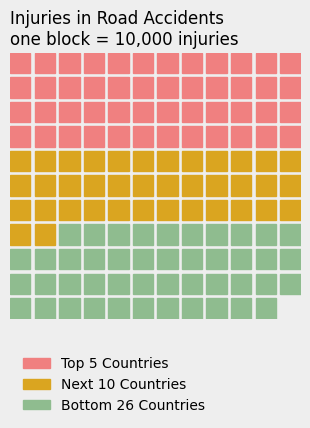

In [255]:
# Waffle Chart

fig = plt.figure(
    FigureClass=Waffle,
    rows=11,
    values=filtered_data,
    colors=['lightcoral','goldenrod','darkseagreen'],
    title={'label': 'Injuries in Road Accidents \none block = 10,000 injuries', 'loc': 'left'},
    labels=[f"{k}" for k, v in filtered_data.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': 1, 'framealpha': 0},
    starting_location='NW',
    vertical=True
)
fig.set_facecolor('#EEEEEE')
plt.show()

In [176]:
# gdp by country
gdp = pd.read_csv('/Users/sarahweinflash/Desktop/Education/CIS 9655 - Data Visualization/WITS-Country-Timeseries.csv')
gdp = gdp.melt(id_vars = 'Country Name', value_vars = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021'], var_name='Year', value_name='GDP')
gdp['Year'] = gdp['Year'].apply(int)
gdp_data = data.merge(gdp, left_on=['Country','Year'], right_on=['Country Name', 'Year'])
gdp_data = gdp_data[['Country','Year','Injuries','GDP']]
#gdp_data = gdp_data[gdp_data['Country']!='United States'] # United States is a GDP outlier 
gdp_data['Transformed_GDP'] = gdp_data['GDP'].apply(np.sqrt)
new_gdp = pd.DataFrame(gdp_data.groupby('Country')[['Transformed_GDP','Injuries']].agg('mean'))
new_gdp = new_gdp.reset_index()

In [187]:
# Bar Chart & Scatter Plot - Selection Interaction
points = alt.Chart(new_gdp, title = 'Road Accidents & GDP, 2010-2022').mark_point(filled=True, color='seagreen',opacity=1).encode(
    alt.X('Transformed_GDP:Q', title='Average square root of GDP'),
    alt.Y('Injuries:Q', title='Average injuries per country'),
    tooltip = ['Country']
)

points + points.transform_regression('Transformed_GDP','Injuries').mark_line(opacity=1, color='black')

alt.LayerChart(...)